## Project Description:
Suppose you are a trader working on a bank’s option trading desk. A customer comes to you with the belief that the price of The Walt Disney Company stock (NYSE : DIS), we denote it S, will have increased above USD100 in one year. She wants to buy a call option to profit off of that. You need to price the call option while analysing quantitatively the impacts of different parameters and design a replication strategy to hedge the deals, within your firm’s risk management requirements.

In [ ]:
#Import different libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
import math
import scipy.optimize as optimize


### Call option pricing
We try to price the call option mentioned above using Monte Carlo simulations and the Black-scholes model

In [ ]:
Disney_data = yf.download("DIS", start="2013-12-01", end="2023-12-01")
Disney_df = Disney_data['Adj Close']
Disney_df.dropna()
Disney_df.head(-5)

[*********************100%%**********************]  1 of 1 completed


Date
2013-12-02    64.254364
2013-12-03    63.339153
2013-12-04    63.402596
2013-12-05    63.638199
2013-12-06    64.752731
                ...    
2023-11-16    94.202988
2023-11-17    93.844154
2023-11-20    94.721291
2023-11-21    94.143173
2023-11-22    94.761162
Name: Adj Close, Length: 2512, dtype: float64

In [ ]:
#number of trading days per year
len(Disney_df)/10
#251.7

251.7

In [ ]:
Disney_df.describe()

count    2517.000000
mean      111.212010
std        28.614841
min        63.339153
25%        92.986946
50%       102.830376
75%       124.574005
max       201.254089
Name: Adj Close, dtype: float64

In [ ]:
# Assumption values
S0 = 91.2
K = 100
T = 1
r = 0.04

adj_close = Disney_data['Adj Close']
daily_returns = adj_close.pct_change().dropna()
sigma = daily_returns.std() * np.sqrt(251.7)
Tenyears_volatility= sigma
num_simulations = 500000
print("The volatily of the 10 years historic data to price the options is = ", sigma)

The volatily of the 10 years historic data to price the options is =  0.2717962685229473


In [ ]:
def monte_carlo_call_option_price(S0, K, T, r, sigma, num_simulations):
    dt = T / 252
    stock_prices = np.zeros((num_simulations, 252 + 1))
    stock_prices[:, 0] = S0

    for i in range(1, 252 + 1):
        Z = np.random.normal(0, 1, num_simulations)
        stock_prices[:, i] = stock_prices[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    call_payoffs = np.maximum(stock_prices[:, -1] - K, 0)
    call_option_price = np.exp(-r * T) * np.mean(call_payoffs)

    return call_option_price



# Calculate Monte-Carlo option price
option_price_mc = monte_carlo_call_option_price(S0, K, T, r, sigma, num_simulations)


#Black-Scholes formula
def black_scholes_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price
#Calculate Black-Scholes price
option_price_bs = black_scholes_call_price(S0, K, T, r, sigma)

In [ ]:
#after 1/2 mil iterations: price is around 7.85
print(f'Black-Scholes Option Price: {option_price_bs}')
print(f'Monte-Carlo Option Price: {option_price_mc}')


Black-Scholes Option Price: 7.867102239832938
Monte-Carlo Option Price: 7.832854705997496


### Analyzing the impacts of each parameter quantitatively

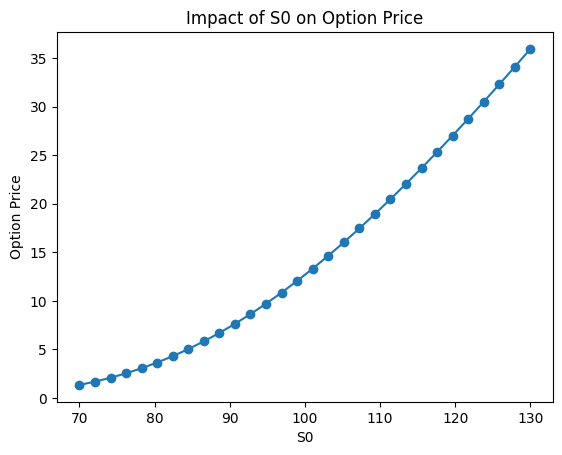

<ipython-input-53-499c91817b8a>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


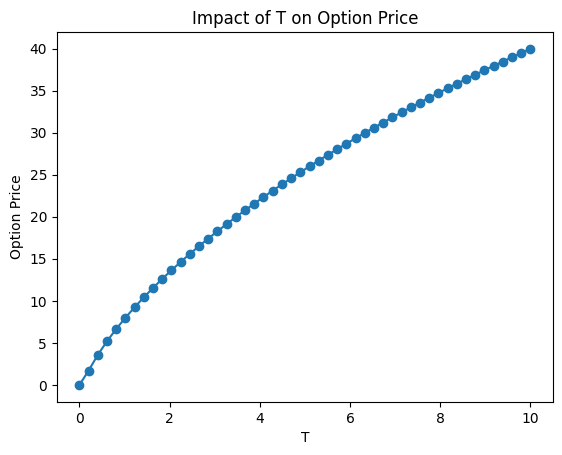

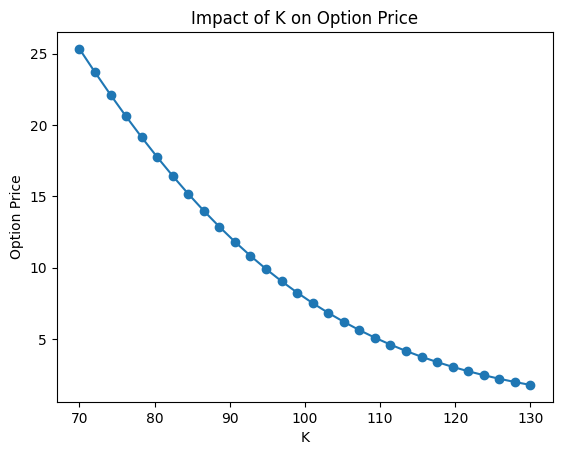

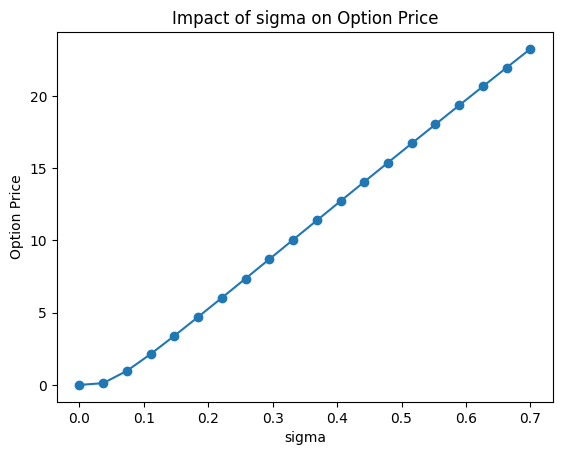

<Figure size 640x480 with 0 Axes>

In [ ]:
def analyze_parameter(parameter_values, parameter_name, fixed_parameters):
    option_prices = []
    for param_value in parameter_values:
        #Updating the parameter in fixed_parameters
        fixed_parameters[parameter_name] = param_value
        option_price = black_scholes_call_price(**fixed_parameters)
        option_prices.append(option_price)

    #Plotting results
    plt.plot(parameter_values, option_prices, marker='o')
    plt.title(f'Impact of {parameter_name} on Option Price')
    plt.xlabel(parameter_name)
    plt.ylabel('Option Price')
    plt.show()

    return option_prices



# Impact of starting price S0
starting_prices = np.linspace(70, 130, 30)
analyze_parameter(starting_prices, 'S0', {'K': K, 'T': T, 'r': r, 'sigma': Tenyears_volatility})

# Impact of time-to-maturity T
maturities = np.linspace(0, 10, 50)
analyze_parameter(maturities, 'T', {'S0': S0, 'K': K, 'r': r, 'sigma': Tenyears_volatility})

# Impact of strike prices K
strike_prices = np.linspace(70, 130, 30)
analyze_parameter(strike_prices, 'K', {'S0': S0, 'T': T, 'r': r, 'sigma': Tenyears_volatility})

# Impact of volatility sigma
volatilities = np.linspace(0, 0.7, 20)
analyze_parameter(volatilities, 'sigma', {'S0': S0, 'K': K, 'T': T, 'r': r})

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# delta under different call option price
def compute_pair_delta_price(S0,K,T,r,sigma):
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  delta = norm.cdf(d1)
  call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return call_price, delta

Call Price: 0.34628219608253863, S0: 60.0, $\delta$ 0.05520244461281416
Call Price: 0.8675366350673652, S0: 66.42857142857143, $\delta$ 0.11087379200676245
Call Price: 1.8200395151378395, S0: 72.85714285714286, $\delta$ 0.18887975413856517
Call Price: 3.3329309184566647, S0: 79.28571428571428, $\delta$ 0.2840248291335706
Call Price: 5.491095460023637, S0: 85.71428571428572, $\delta$ 0.38817144930770886
Call Price: 8.324657851459236, S0: 92.14285714285714, $\delta$ 0.4928178422934717
Call Price: 11.81330216259137, S0: 98.57142857142857, $\delta$ 0.5910037555232108
Call Price: 15.899481444144364, S0: 105.0, $\delta$ 0.6781662900157053
Call Price: 20.504164602236195, S0: 111.42857142857143, $\delta$ 0.7521305198019549
Call Price: 25.540757912146347, S0: 117.85714285714286, $\delta$ 0.8126153800255878
Call Price: 30.92522478021634, S0: 124.28571428571429, $\delta$ 0.8605909901022442
Call Price: 36.582187285867704, S0: 130.71428571428572, $\delta$ 0.8976947189058878
Call Price: 42.447723021

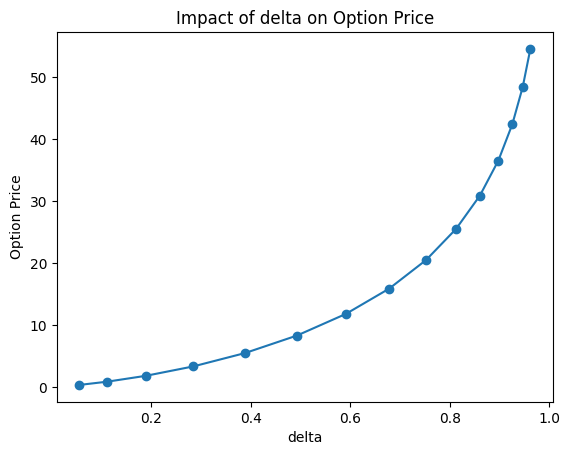

In [ ]:
# plot the pairs of price and delta
S0s = np.linspace(60,150,15)
call_prices = []
deltas = []
for S in S0s:
  call_price, delta = compute_pair_delta_price(S,K,T,r,sigma)
  call_prices.append(call_price)
  deltas.append(delta)
  print(f"Call Price: {call_price}, S0: {S}, $\delta$ {delta}")

plt.plot(deltas, call_prices, marker='o')
plt.title(f'Impact of {"delta"} on Option Price')
plt.xlabel("delta")
plt.ylabel('Option Price')
plt.show()

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17',
               ...
               '2023-11-16', '2023-11-17', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-24', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', name='Date', length=230, freq=None)

In [ ]:
def analyze_2parameters(parameter_values1, parameter_name1, parameter_values2, parameter_name2, fixed_parameters):
    for value1 in parameter_values1:
        option_prices = []

        for value2 in parameter_values2:
            # Updating the parameters in fixed_parameters
            fixed_parameters[parameter_name1] = value1
            fixed_parameters[parameter_name2] = value2

            # Calculating option price for the given parameters
            option_price = black_scholes_call_price(**fixed_parameters)
            option_prices.append(option_price)

        # Plotting results for each value of parameter2
        plt.plot(parameter_values2, option_prices, label=f'{parameter_name1} = {value1:.2f}')

    plt.title(f'Impact of {parameter_name2} on Option Price for Different {parameter_name1}')
    plt.xlabel(parameter_name2)
    plt.ylabel('Option Price')
    plt.legend()
    plt.show()



<ipython-input-5-499c91817b8a>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


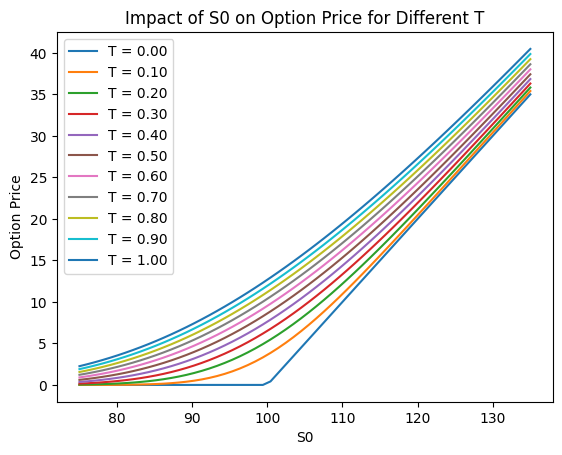

In [ ]:
#Impact of starting price S0 and T
starting_prices = np.linspace(75, 135, 60)
maturities = np.linspace(0.0, 1, 11)
analyze_2parameters( maturities, 'T', starting_prices, 'S0', {'K': K, 'r': r, 'sigma': Tenyears_volatility})

<ipython-input-5-499c91817b8a>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


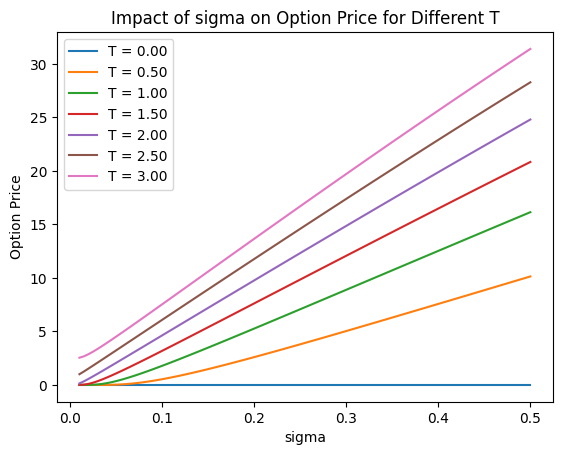

In [ ]:
#Impact of volatility sigma and T
volatilities = np.linspace(0.01, 0.5, 100)
maturities = np.linspace(0, 3, 7)
analyze_2parameters(maturities, 'T', volatilities, 'sigma', {'K': K, 'r': r, 'S0' : S0})

<ipython-input-5-499c91817b8a>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


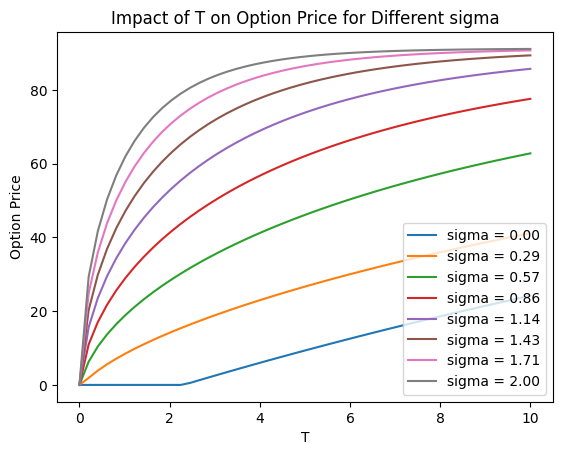

In [ ]:
#Impact of volatility sigma and T
volatilities = np.linspace(0, 2, 8)
maturities = np.linspace(0, 10, 50)
analyze_2parameters(volatilities, 'sigma', maturities, 'T', {'K': K, 'r': r, 'S0' : S0})

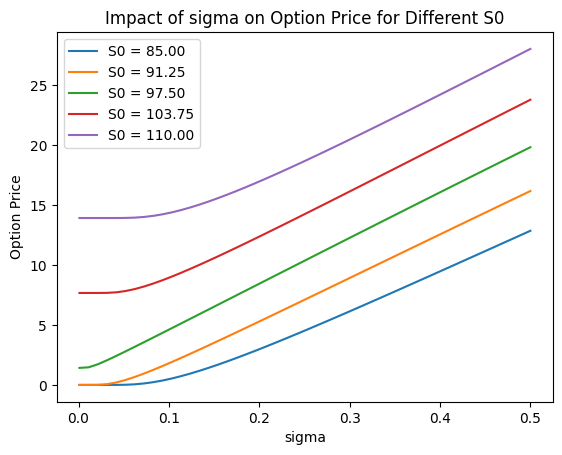

In [ ]:
#Impact of volatility sigma and strating price
volatilities = np.linspace(0.001, 0.5, 50)
starting_prices = np.linspace(85, 110, 5)
analyze_2parameters(starting_prices, 'S0', volatilities, 'sigma', {'K': K, 'r': r, 'T' : T})

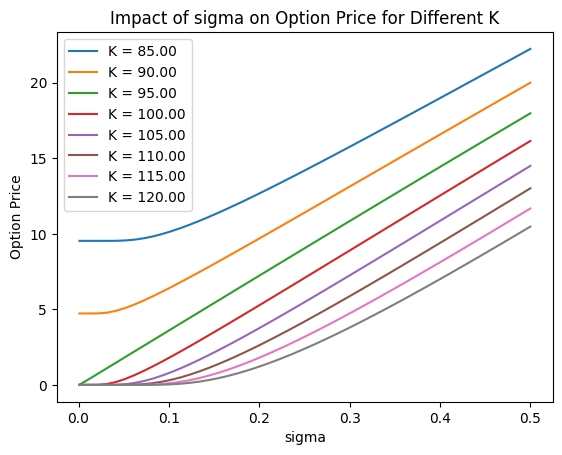

In [ ]:
#Impact of strike prices K and sigma
strike_prices = np.linspace(85, 120, 8)
volatilities = np.linspace(0.001, 0.5, 50)
analyze_2parameters(strike_prices, 'K', volatilities, 'sigma', {'S0': S0, 'r': r, 'T' : T})


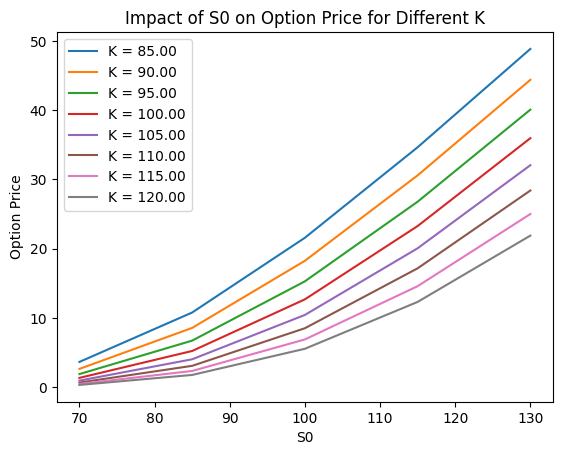

In [ ]:
#Impact of strike prices K and starting price
strike_prices = np.linspace(85, 120, 8)
starting_prices = np.linspace(70, 130, 5)
analyze_2parameters(strike_prices, 'K', starting_prices, 'S0', {'sigma': Tenyears_volatility, 'r': r, 'T' : T})

<ipython-input-53-499c91817b8a>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


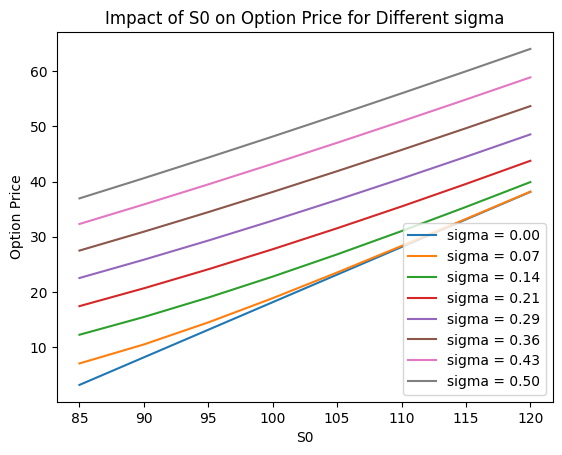

In [ ]:
#Impact of sigma and starting price
starting_prices = np.linspace(85, 120, 8)
volatilities = np.linspace(0, 0.5, 8)
analyze_2parameters(volatilities, 'sigma', starting_prices, 'S0', {'K': K, 'r': r, 'T' : T})

<ipython-input-53-499c91817b8a>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


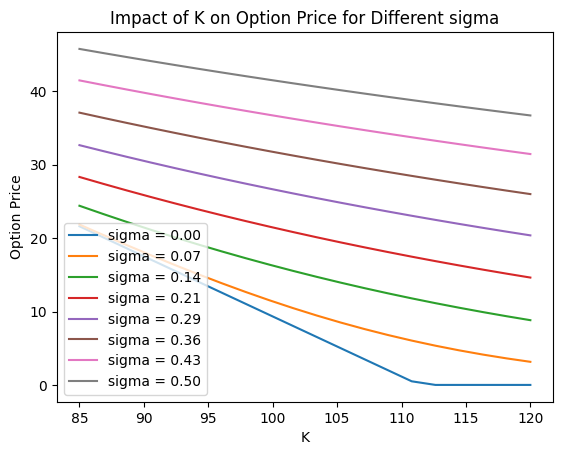

In [ ]:
#Impact of sigma and starting price
strike_prices = np.linspace(85, 120, 20)
volatilities = np.linspace(0, 0.5, 8)
analyze_2parameters(volatilities, 'sigma', strike_prices, 'K', {'S0': S0, 'r': r, 'T' : T})

<ipython-input-53-499c91817b8a>:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


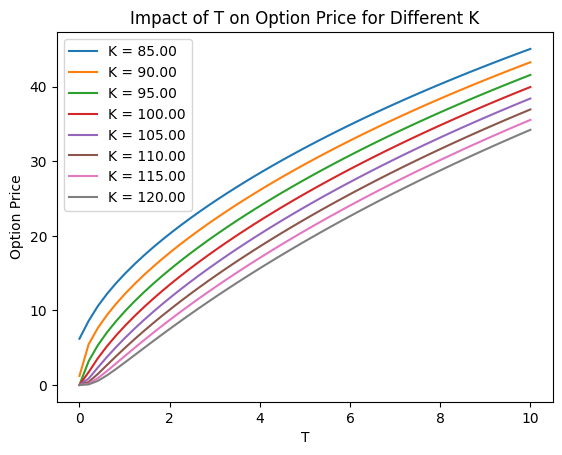

In [ ]:

strike_prices = np.linspace(85, 120, 8)
maturities = np.linspace(0, 10, 50)
analyze_2parameters(strike_prices, 'K', maturities, 'T', {'S0': S0, 'r': r, 'sigma' : sigma})

## Replication Strategy for Delta-Hedging
We assume that the trajectory of the underlying follows a Geometry Brownian Motion. Suppose that the starting price S0 is the current value of DIS. Consider TTM=1y by default. Consider a risk-free rate of r = 4% (10Y U.S. Treasury Bonds)

## Implementation of the replication strategy

Text(0.5, 1.0, 'Sample Path of GBM')

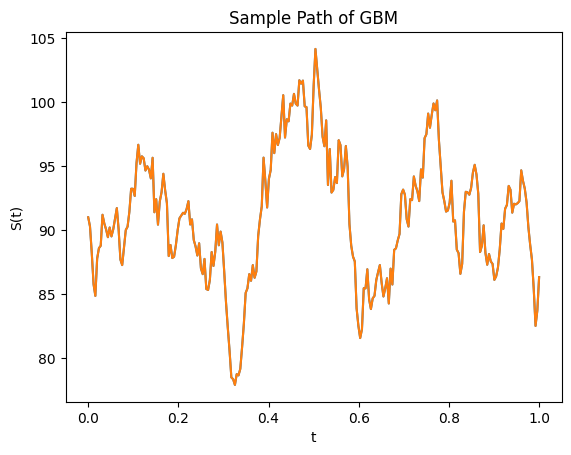

In [ ]:
##PART TWO : Replicating strategy
#Simulation of the stock price
def GBM_sim(S, mu, T, sigma, N):
    dt = 1/(T*252)
    W = np.random.standard_normal(size=N)
    W = np.array([0] + list(np.cumsum(W)*np.sqrt(dt)))
    t = np.linspace(0, T, N+1)
    S = S*np.exp((mu - 0.5*sigma**2)*t + sigma*W)
    return S,t

# Plotting sample path
path = GBM_sim(91, r, 1, sigma, 252);plt.plot(path[1], path[0])

plt.plot(path[1], path[0])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Sample Path of GBM')




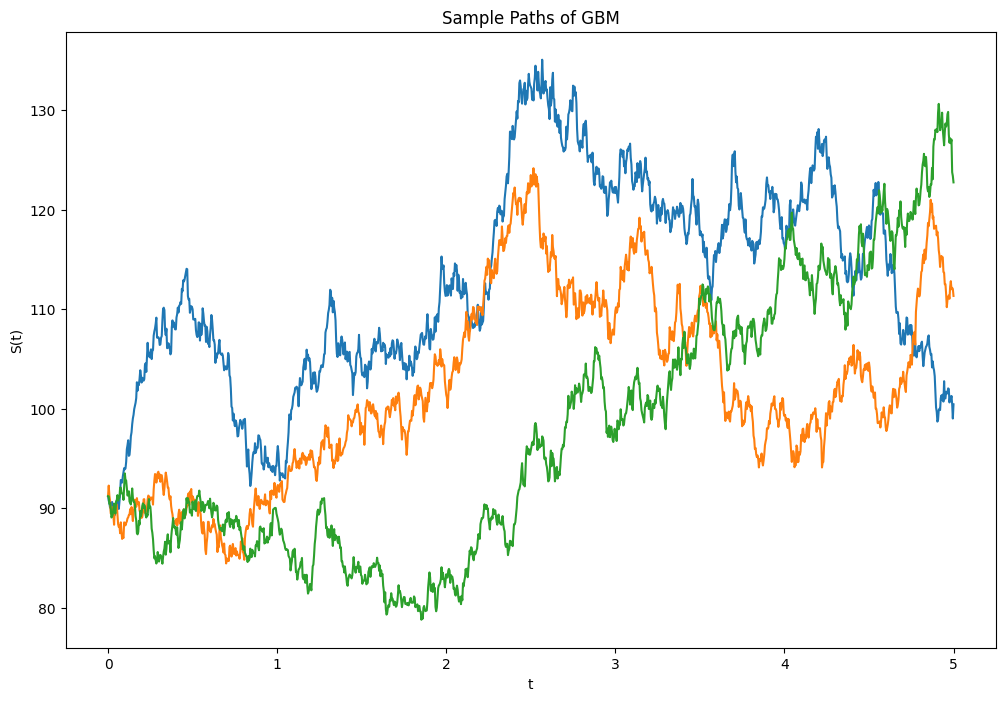

In [ ]:
# Plotting 3 sample paths

num_simulations = 3
S0 = 91.2
r = 0.04
sigma = Tenyears_volatility

plt.figure(figsize=(12, 8))

for _ in range(num_simulations):
    path = GBM_sim(S0, r, 1, sigma, 252*T)
    plt.plot(path[1], path[0])

plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Sample Paths of GBM')
plt.show()

In [ ]:
def compute_delta(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1)

In [ ]:
#Initial Portfolio
d_initial = compute_delta(S0,K,T,r,sigma)
a = black_scholes_call_price(S0, K, T, r, sigma)
portfolio_values = a
equity = d_initial*S0
cash = portfolio_values-equity

print(d_initial, a, equity, cash)


0.4777323198732877 7.867102239832938 43.56918757244384 -35.7020853326109


Text(0.5, 1.0, 'Variation of Delta w/ Initial Stock Price')

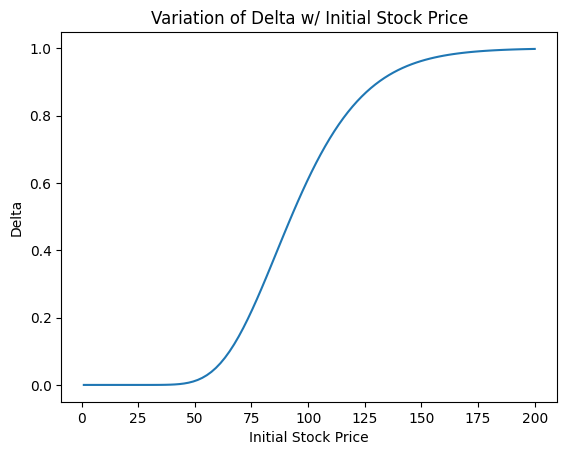

In [ ]:
#Influence of the initial stock price on the delta at time t=0
S = np.linspace(1, 200, 100)
d = compute_delta(S, K, T, r, sigma)

plt.plot(S, d)
plt.xlabel('Initial Stock Price')
plt.ylabel('Delta')
plt.title('Variation of Delta w/ Initial Stock Price')

<ipython-input-9-01ce9a3020c2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


13.752579568342917 0 13.752579568342917


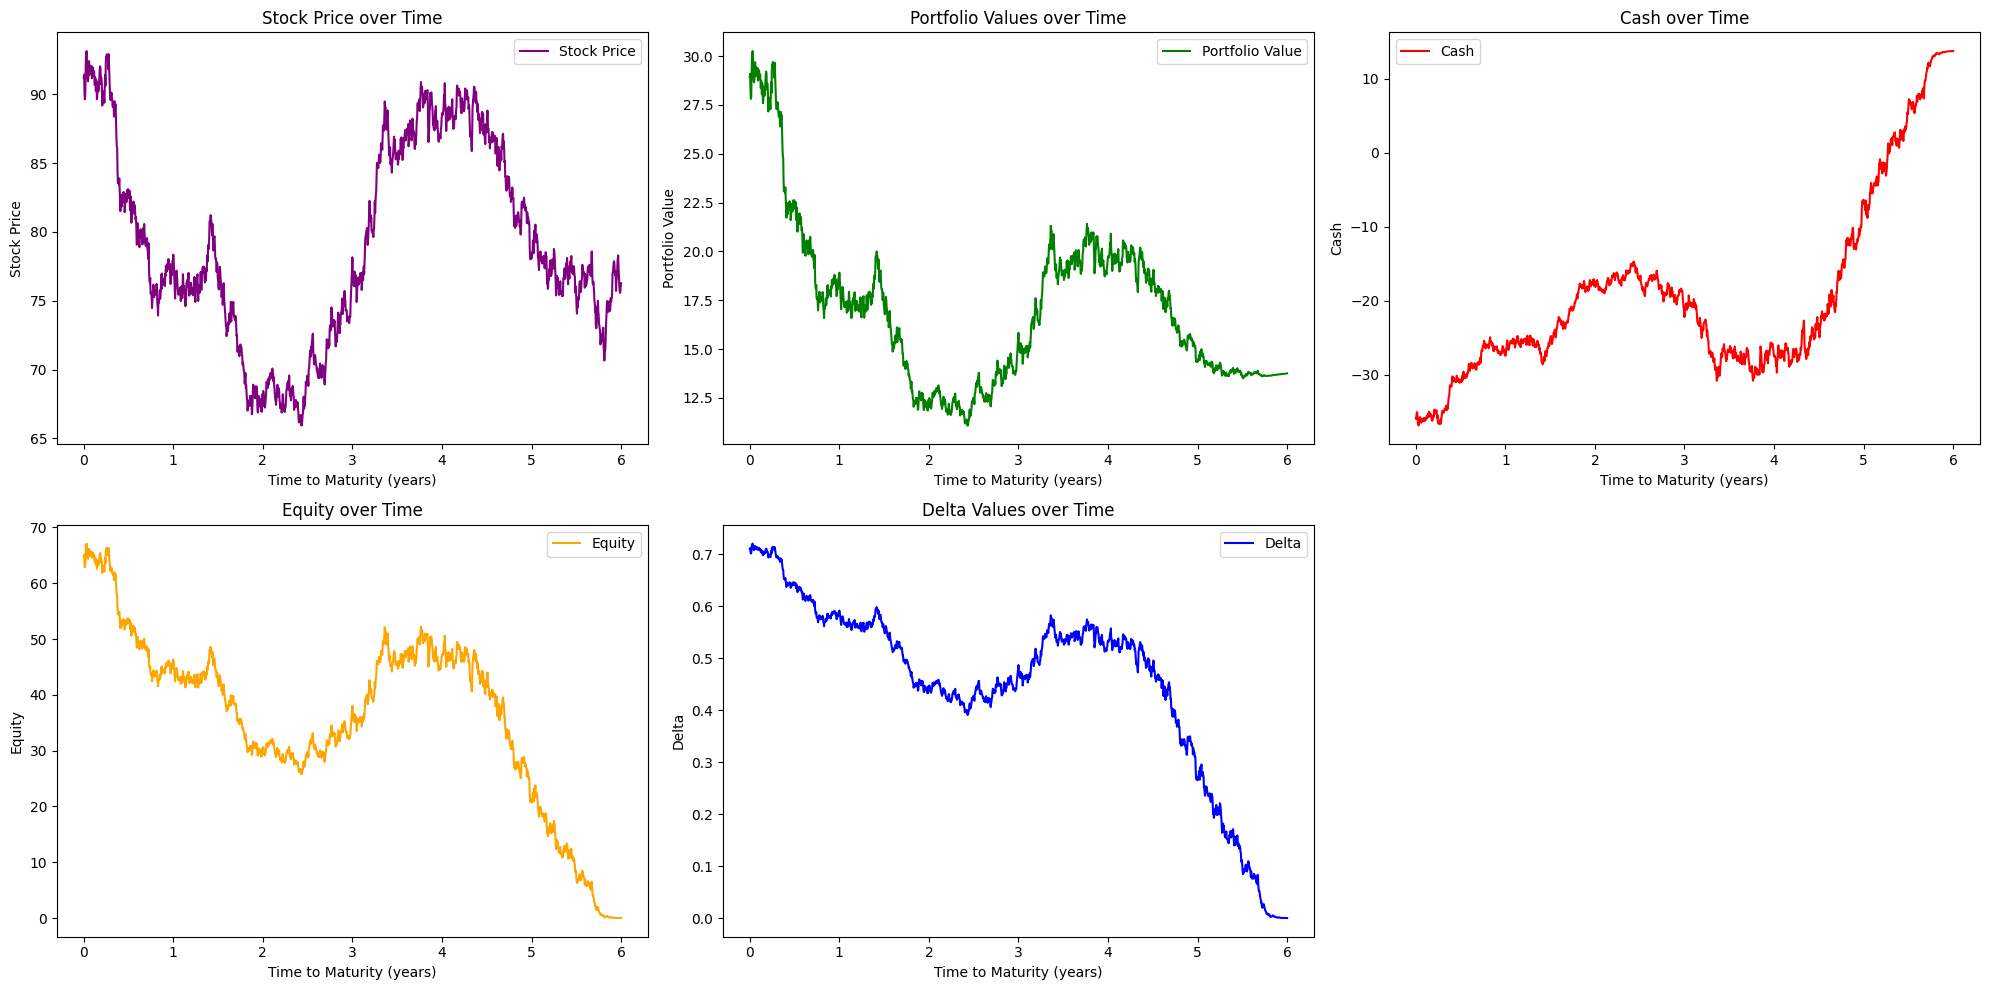

In [ ]:
###Question 2.1.
S0 = 91.2; K = 100; T = 1.0; r = 0.04; sigma = Tenyears_volatility

step = 1 #determine the frequency of the rebalancing

path = GBM_sim(S0, r, T, sigma , int(T*252))

St = path[0]
t = path[1]
dt = 1/252

d_initial = compute_delta(St[0], K, T, r, sigma)
a = black_scholes_call_price(S0, K, T, r, sigma)

portfolio_values = [a]
delta_values = [d_initial]
equity = [delta_values[0]*S0]
cash = [portfolio_values[0]-equity[0]]

# Rebalancing
for i in range(1, len(t)):
    x = t[i]
    if i % step == 0:
      portfolio_values.append(cash[-1] * np.exp(r * dt) + delta_values[-1] * St[i])
      ttm = T - x
      delta = compute_delta(St[i], K, ttm, r, sigma)
      delta_values.append(delta)
      equity.append(delta * St[i])
      cash.append(portfolio_values[-1] - equity[-1])

    else :
      delta = delta_values[-1]
      delta_values.append(delta)
      equity.append(delta * St[i])
      cash.append(cash[-1]*np.exp(r * dt))
      portfolio_values.append(cash[-1] + equity[-1])




payoff = max(St[-1]-K, 0)
error = portfolio_values[-1]-payoff

print(portfolio_values[-1], payoff, error)

# Initialize lists for plotting
plt.figure(figsize=(20, 10))

# Plot Stock Price
plt.subplot(2, 3, 1)
plt.plot(t, St, label='Stock Price', color='purple')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Stock Price')
plt.title('Stock Price over Time')
plt.legend()

# Plot Portfolio Value
plt.subplot(2, 3, 2)
plt.plot(t, portfolio_values, label='Portfolio Value', color='green')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Values over Time')
plt.legend()

# Plot Cash
plt.subplot(2, 3, 3)
plt.plot(t, cash, label='Cash', color='red')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Cash')
plt.title('Cash over Time')
plt.legend()

# Plot Equity
plt.subplot(2, 3, 4)
plt.plot(t, equity, label='Equity', color='orange')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Equity')
plt.title('Equity over Time')
plt.legend()

# Plot Delta values
plt.subplot(2, 3, 5)
plt.plot(t, delta_values, label='Delta', color='blue')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Delta')
plt.title('Delta Values over Time')
plt.legend()


plt.tight_layout()
plt.show()


<ipython-input-12-01ce9a3020c2>:2: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


Text(0.5, 1.0, 'Variation of Delta w/ Final Stock Price')

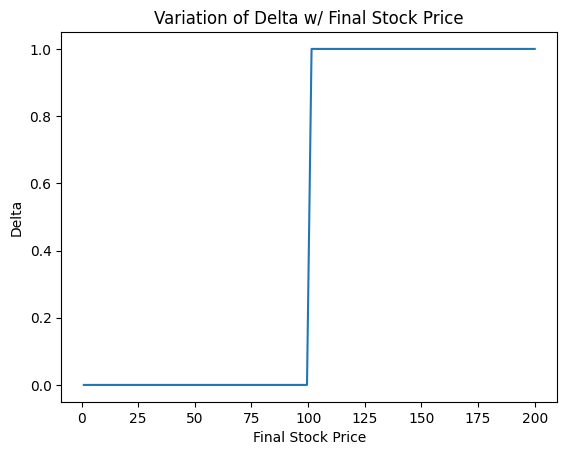

In [ ]:
#Influence of the initial stock price on the delta at time t=0
T_maturity = 0
S = np.linspace(1, 200, 100)
d = compute_delta(S, K, T_maturity, r, sigma)

plt.plot(S, d)
plt.xlabel('Final Stock Price')
plt.ylabel('Delta')
plt.title('Variation of Delta w/ Final Stock Price')

<ipython-input-9-01ce9a3020c2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


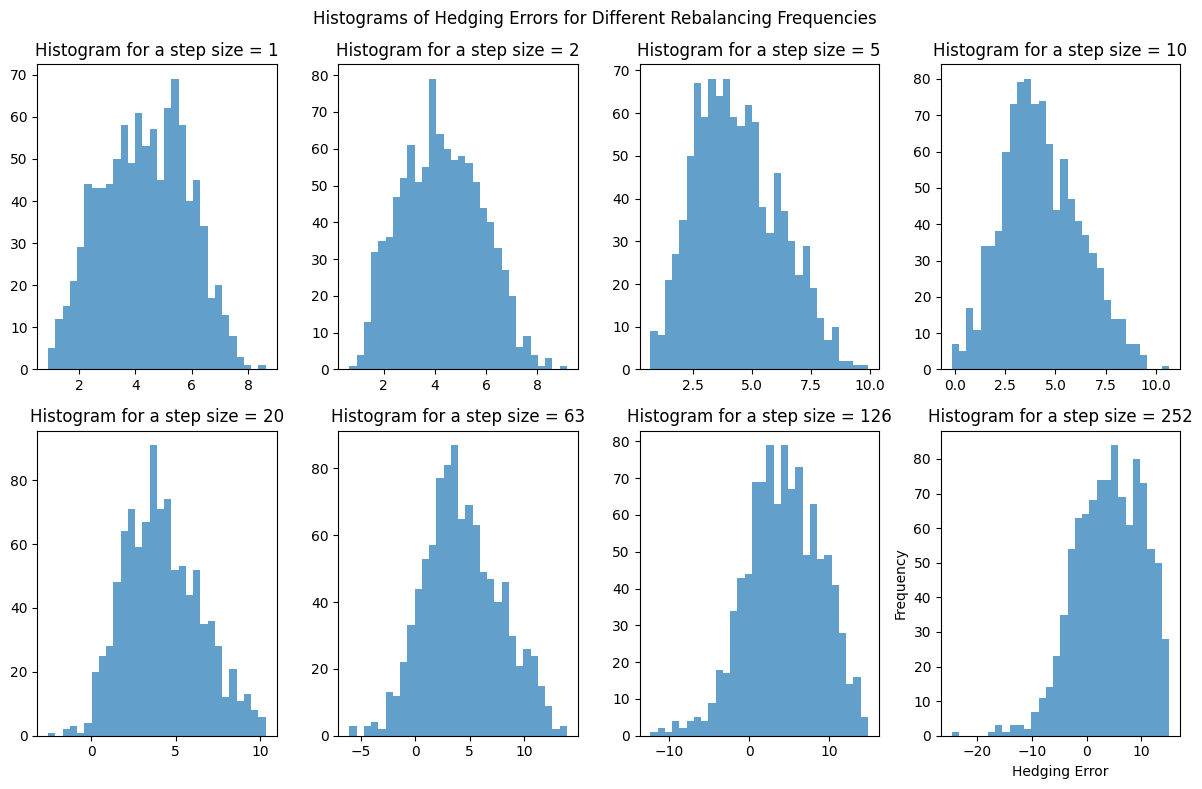

In [ ]:
###Code for question 2.2.
S0 = 91.2
K = 100
T = 2
r = 0.04
sigma = Tenyears_volatility

N_steps = [1, 2, 5, 10, 20, 63, 126, 252]
num = 1000
dt = 1/252

error = np.zeros((num, len(N_steps)))

for n in range(num):

    for j in range(len(N_steps)):
        step = N_steps[j]
        path = GBM_sim(S0, r, T, sigma, 252*T)
        St = path[0]
        t = path[1]

        d_initial = compute_delta(St[0], K, T, r, sigma)
        a = black_scholes_call_price(S0, K, T, r, sigma)

        portfolio_values = [a]
        delta_values = [d_initial]
        equity = [delta_values[0] * S0]
        cash = [portfolio_values[0] - equity[0]]

        # Rebalancing
        for i in range(1, len(t)):

          x = t[i]
          if i % step == 0:
              portfolio_values.append(cash[-1] * np.exp(r * dt) + delta_values[-1] * St[i])
              ttm = T - x
              delta = compute_delta(St[i], K, ttm, r, sigma)
              delta_values.append(delta)
              equity.append(delta * St[i])
              cash.append(portfolio_values[-1] - equity[-1])

          else :
              delta = delta_values[-1]
              delta_values.append(delta)
              equity.append(delta * St[i])
              cash.append(cash[-1]*np.exp(r * dt))
              portfolio_values.append(cash[-1] + equity[-1])

        payoff = max(St[-1] - K, 0)
        error[n, j] = portfolio_values[-1] - payoff

# Plot histograms for hedging errors
plt.figure(figsize=(12, 8))

for i, step in enumerate(N_steps):
    plt.subplot(2, 4, i + 1)
    plt.hist(error[:, i], bins=30, alpha=0.7)
    plt.title(f'Histogram for a step size = {step}')

plt.xlabel('Hedging Error')
plt.ylabel('Frequency')
plt.suptitle('Histograms of Hedging Errors for Different Rebalancing Frequencies')
plt.tight_layout()
plt.show()

# plot them in one graph


<ipython-input-9-01ce9a3020c2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


The mean of total_cost for the step size = 1 is: 2.5555829773862464
1 The 10% VaR of hedging errors is: -4.202046105796678
The mean of total_cost for the step size = 2 is: 1.8974045550778538
2 The 10% VaR of hedging errors is: -3.468902062428724
The mean of total_cost for the step size = 5 is: 1.267418527878412
5 The 10% VaR of hedging errors is: -3.0549422912063604
The mean of total_cost for the step size = 10 is: 0.9621174404025812
10 The 10% VaR of hedging errors is: -3.2837457942107924
The mean of total_cost for the step size = 20 is: 0.7335713362496584
20 The 10% VaR of hedging errors is: -3.8040176379919677
The mean of total_cost for the step size = 50 is: 0.5819637507250971
50 The 10% VaR of hedging errors is: -5.1520190413683435
The mean of total_cost for the step size = 63 is: 0.5623591975763088
63 The 10% VaR of hedging errors is: -5.7077868948826325
The mean of total_cost for the step size = 100 is: 0.4247640690122702
100 The 10% VaR of hedging errors is: -6.661614832887282


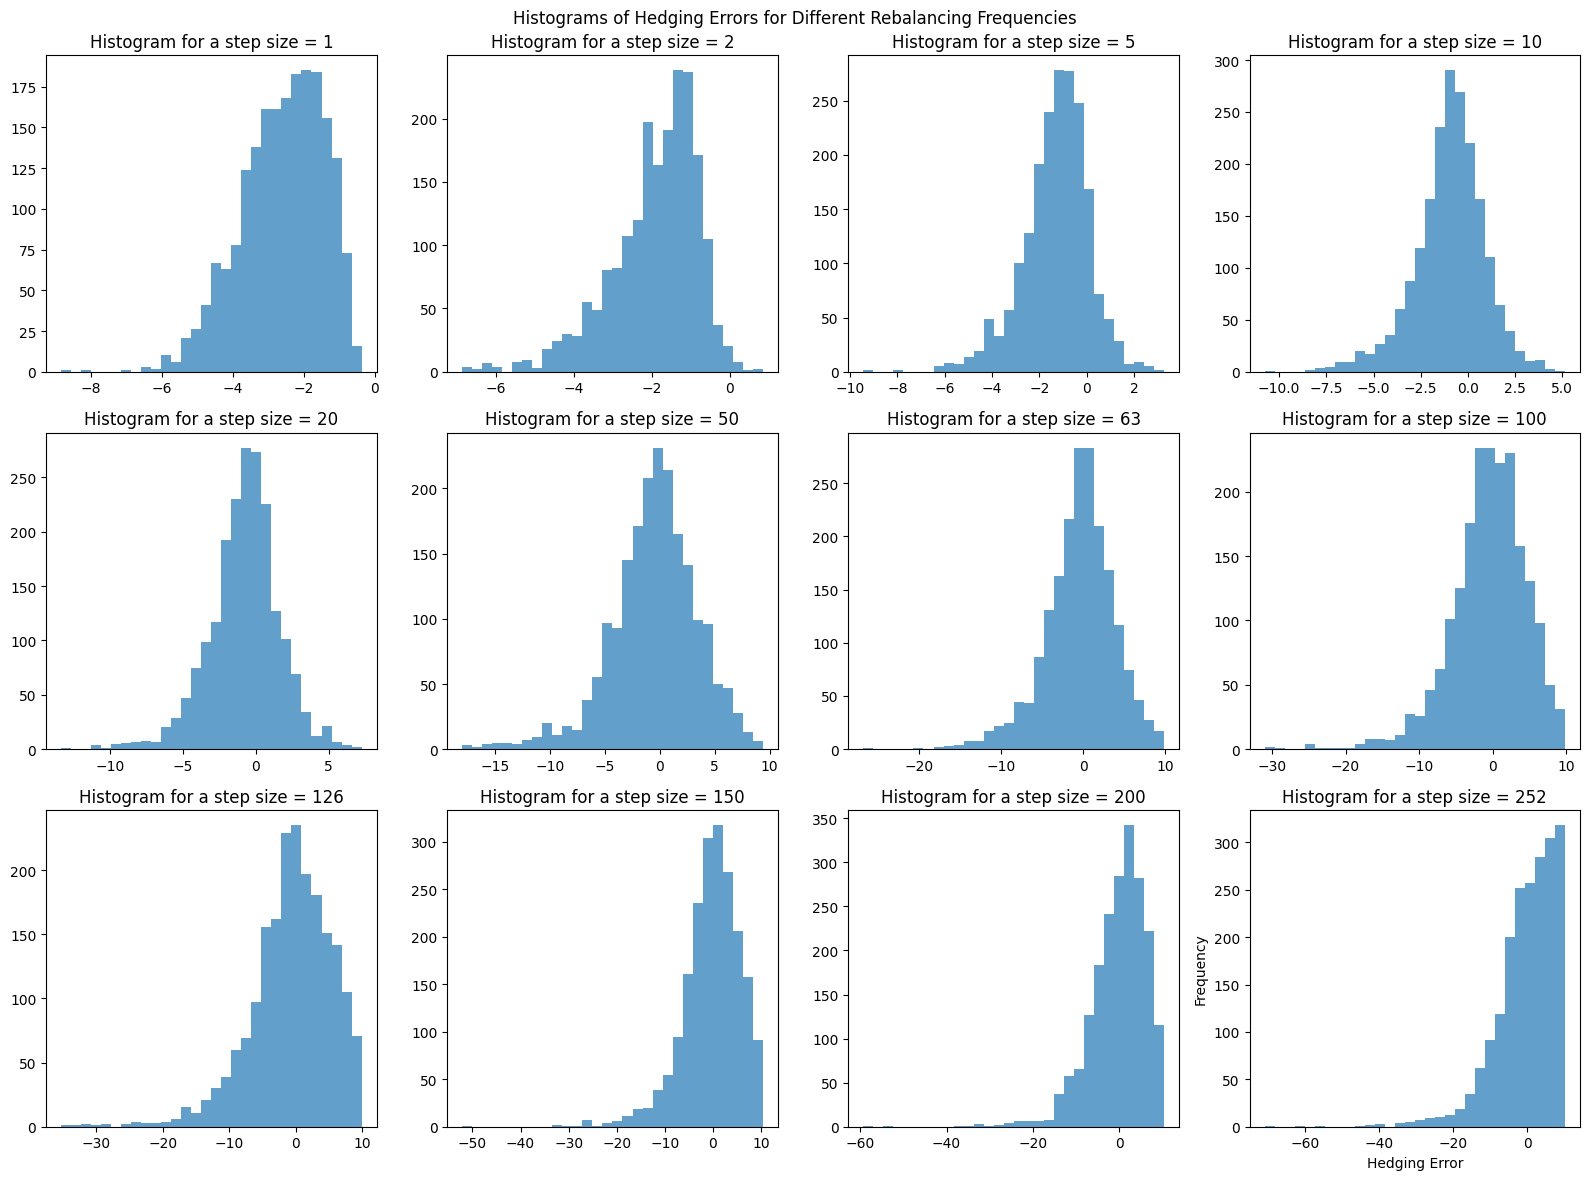

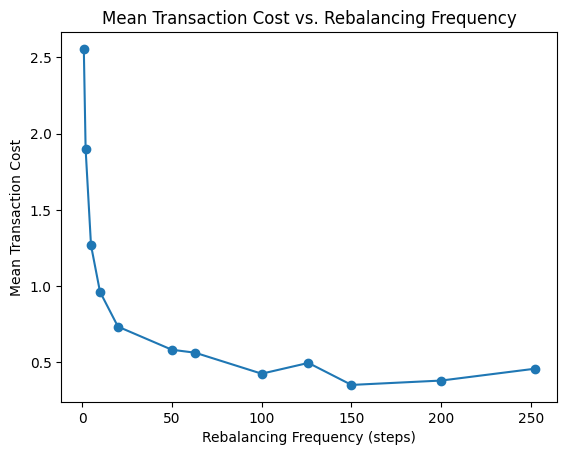

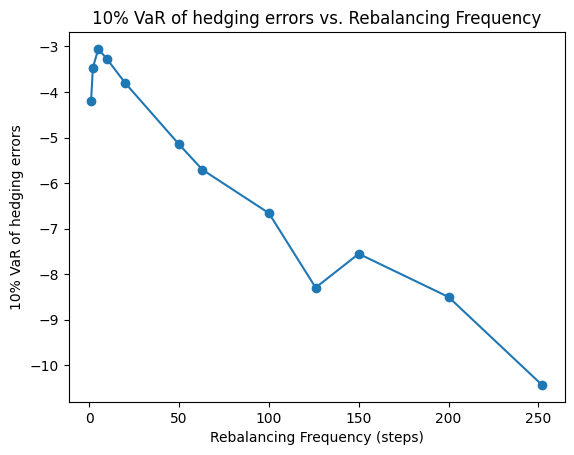

In [ ]:
###Code for question 2.3.
transaction_cost = 50/10000
S0 = 91.2
K = 100
T = 1.0
r = 0.04
sigma = Tenyears_volatility

N_steps = [1, 2, 5, 10, 20, 50, 63, 100, 126, 150, 200, 252]
num = 2000
dt = 1/252

error = np.zeros((num, len(N_steps)))
total_cost = np.zeros((num, len(N_steps)))
mean_transaction_costs = []
var = []

for n in range(num):

    for j in range(len(N_steps)):
        step = N_steps[j]
        path = GBM_sim(S0, r, T, sigma, 252)
        St = path[0]
        t = path[1]

        d_initial = compute_delta(St[0], K, T, r, sigma)
        a = black_scholes_call_price(S0, K, T, r, sigma)
        initial_cost = d_initial * S0 * transaction_cost
        total_cost[n, j] += initial_cost

        portfolio_values = [a-initial_cost]
        delta_values = [d_initial]
        equity = [delta_values[0] * S0]
        cash = [portfolio_values[0] - equity[0]]

        # Rebalancing
        for i in range(1, len(t)):

          x = t[i]
          if i % step == 0:
              portfolio_values.append(cash[-1] * np.exp(r * dt) + delta_values[-1] * St[i])
              ttm = T - x
              delta = compute_delta(St[i], K, ttm, r, sigma)
              transaction_cost_amount = transaction_cost * np.abs((delta_values[i-1] - delta) * St[i])
              total_cost[n, j] += transaction_cost_amount
              delta_values.append(delta)
              portfolio_values.append(cash[i - 1] * np.exp(r * dt) + delta_values[i - 1] * St[i] - transaction_cost_amount)
              equity.append(delta * St[i])
              cash.append(portfolio_values[-1] - equity[-1])

          else :
              delta = delta_values[-1]
              delta_values.append(delta)
              equity.append(delta * St[i])
              cash.append(cash[-1]*np.exp(r * dt))
              portfolio_values.append(cash[-1] + equity[-1])

        payoff = max(St[-1] - K, 0)
        error[n, j] = portfolio_values[-1] - payoff

# Plot histograms for hedging errors
plt.figure(figsize=(16, 12))

for i, step in enumerate(N_steps):
    plt.subplot(3, 4, i + 1)
    plt.hist(error[:, i], bins=30, alpha=0.7)
    plt.title(f'Histogram for a step size = {step}')
    mean_value = np.mean(total_cost[:, i])
    mean_transaction_costs.append(mean_value)
    print(f"The mean of total_cost for the step size = {step} is: {mean_value}")
    var_10 = np.percentile(error[:,i], 10)
    var.append(var_10)
    print(step, f"The 10% VaR of hedging errors is: {var_10}")


# Plot the error histograms
plt.xlabel('Hedging Error')
plt.ylabel('Frequency')
plt.suptitle('Histograms of Hedging Errors for Different Rebalancing Frequencies')
plt.tight_layout()
plt.show()

# Plot the mean transaction costs
plt.plot(N_steps, mean_transaction_costs, marker='o')
plt.xlabel('Rebalancing Frequency (steps)')
plt.ylabel('Mean Transaction Cost')
plt.title('Mean Transaction Cost vs. Rebalancing Frequency')
plt.show()

# Plot the 10% error
plt.plot(N_steps, var, marker='o')
plt.xlabel('Rebalancing Frequency (steps)')
plt.ylabel('10% VaR of hedging errors')
plt.title('10% VaR of hedging errors vs. Rebalancing Frequency')
plt.show()


## New Pricing:
As total transaction costs have a substantial impact on hedging errors, such that we must take the transaction costs into account in our pricing. The new price is $p^'_0 = p_0+\alpha$. where $\alpha$ is the supplement on top of the arbitrage-free price $p_0$.
The CRO often reminds us that the risk management requirements are strict: the 10% VaR of the hedging errors must be positive. We are thus looking to lower the price α as much as possible while respecting risk management requirements.

<ipython-input-9-01ce9a3020c2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


The mean of total_cost for the step size = 1 is: 2.5844063082079867
3 The 10% VaR of hedging errors is: -1.0706010002142852
The mean of total_cost for the step size = 2 is: 1.9184239877956069
3 The 10% VaR of hedging errors is: -0.3357615723030166
The mean of total_cost for the step size = 5 is: 1.2713982445977199
3 The 10% VaR of hedging errors is: 0.2676432108281091
The mean of total_cost for the step size = 10 is: 0.9638495868491582
3 The 10% VaR of hedging errors is: 0.009794189943696614
The mean of total_cost for the step size = 20 is: 0.7360471741617404
3 The 10% VaR of hedging errors is: -1.0022932273762577
The mean of total_cost for the step size = 63 is: 0.5660645763912564
3 The 10% VaR of hedging errors is: -3.138374237364806
The mean of total_cost for the step size = 126 is: 0.4907609809356886
3 The 10% VaR of hedging errors is: -5.279484453482445
The mean of total_cost for the step size = 252 is: 0.4562654031649065
3 The 10% VaR of hedging errors is: -7.21954348607671


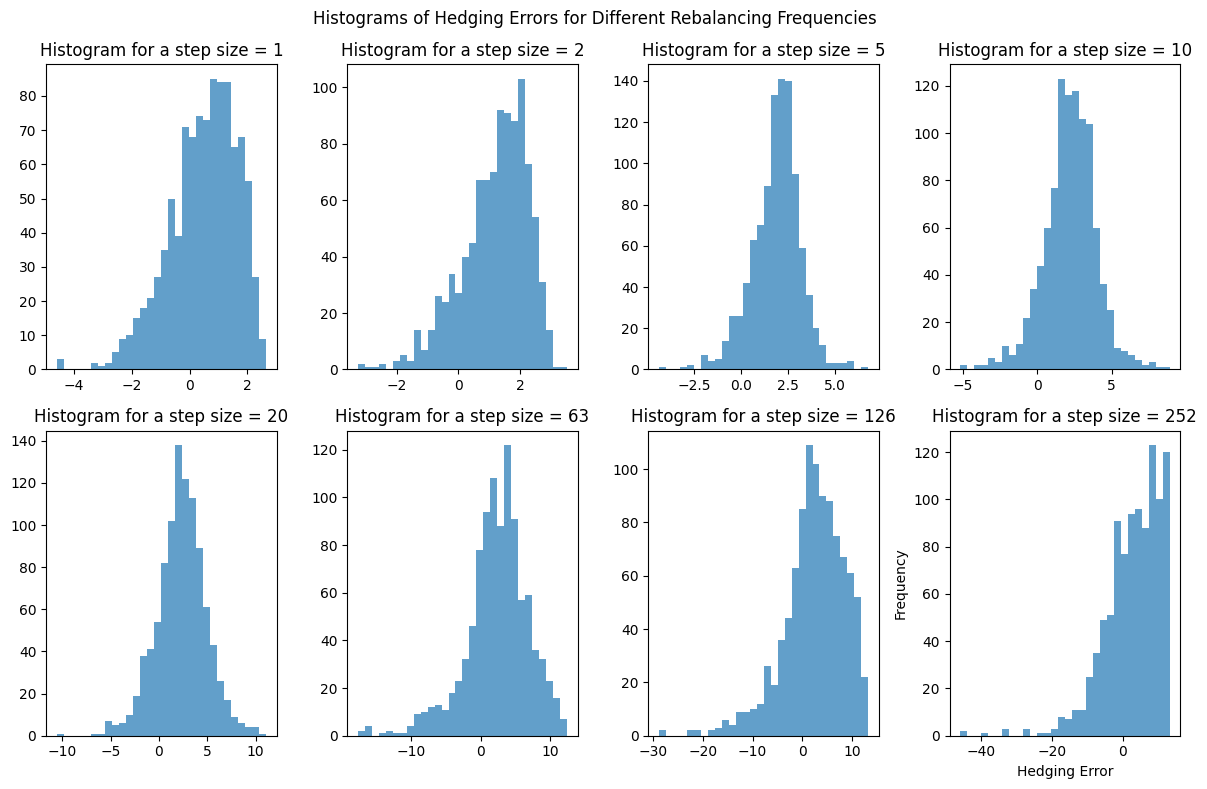

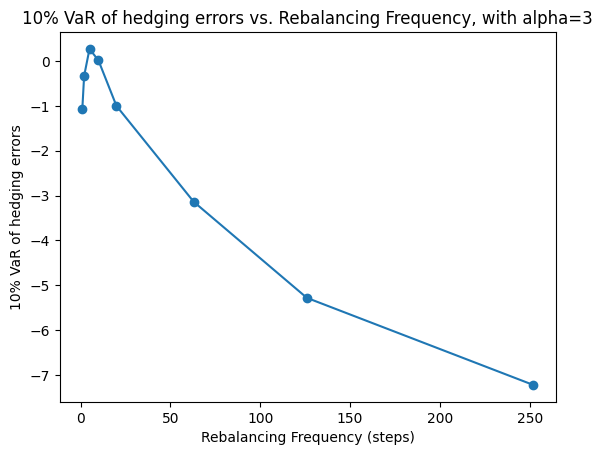

In [ ]:
###Code for question 3.1.
transaction_cost = 50/10000
S0 = 91.2
K = 100
T = 1.0
r = 0.04
sigma = Tenyears_volatility
alpha = 3

N_steps = [1, 2, 5, 10, 20, 63, 126, 252]
num = 1000
dt = 1/252

error = np.zeros((num, len(N_steps)))
total_cost = np.zeros((num, len(N_steps)))
var = []

for n in range(num):

    for j in range(len(N_steps)):

        step = N_steps[j]
        path = GBM_sim(S0, r, T, sigma, 252)
        St = path[0]
        t = path[1]

        d_initial = compute_delta(St[0], K, T, r, sigma)
        a = black_scholes_call_price(S0, K, T, r, sigma)
        initial_cost = d_initial * S0 * transaction_cost
        total_cost[n, j] += initial_cost

        portfolio_values = [a-initial_cost+alpha]
        delta_values = [d_initial]
        equity = [delta_values[0] * S0]
        cash = [portfolio_values[0] - equity[0]]

        # Rebalancing
        for i in range(1, len(t)):

          x = t[i]
          if i % step == 0:
              portfolio_values.append(cash[-1] * np.exp(r * dt) + delta_values[-1] * St[i])
              ttm = T - x
              delta = compute_delta(St[i], K, ttm, r, sigma)
              transaction_cost_amount = transaction_cost * np.abs((delta_values[i-1] - delta) * St[i])
              total_cost[n, j] += transaction_cost_amount
              delta_values.append(delta)
              portfolio_values.append(cash[i - 1] * np.exp(r * dt) + delta_values[i - 1] * St[i] - transaction_cost_amount)
              equity.append(delta * St[i])
              cash.append(portfolio_values[-1] - equity[-1])

          else :
              delta = delta_values[-1]
              delta_values.append(delta)
              equity.append(delta * St[i])
              cash.append(cash[-1]*np.exp(r * dt))
              portfolio_values.append(cash[-1] + equity[-1])

        payoff = max(St[-1] - K, 0)
        error[n, j] = portfolio_values[-1] - payoff

# Plot histograms for hedging errors
plt.figure(figsize=(12, 8))

for i, step in enumerate(N_steps):
    plt.subplot(2, 4, i + 1)
    plt.hist(error[:, i], bins=30, alpha=0.7)
    plt.title(f'Histogram for a step size = {step}')
    mean_value = np.mean(total_cost[:, i])
    print(f"The mean of total_cost for the step size = {step} is: {mean_value}")
    var_10 = np.percentile(error[:,i], 10)
    var.append(var_10)
    print(alpha, f"The 10% VaR of hedging errors is: {var_10}")

plt.xlabel('Hedging Error')
plt.ylabel('Frequency')
plt.suptitle('Histograms of Hedging Errors for Different Rebalancing Frequencies')
plt.tight_layout()
plt.show()

# Plot the 10% error
plt.plot(N_steps, var, marker='o')
plt.xlabel('Rebalancing Frequency (steps)')
plt.ylabel('10% VaR of hedging errors')
plt.title('10% VaR of hedging errors vs. Rebalancing Frequency, with alpha=3')
plt.show()


<ipython-input-9-01ce9a3020c2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


The mean of total_cost for the step size = 2 is: 1.8782553762919618
2 The 10% VaR of hedging errors is: -0.3553058182827135
The mean of total_cost for the step size = 3 is: 1.5846710437794131
3 The 10% VaR of hedging errors is: -0.20674400867882575
The mean of total_cost for the step size = 4 is: 1.4033545538173755
4 The 10% VaR of hedging errors is: -0.1408488131652303
The mean of total_cost for the step size = 5 is: 1.2702228939138476
5 The 10% VaR of hedging errors is: 0.02191549014910673
The mean of total_cost for the step size = 6 is: 1.1810371691022619
6 The 10% VaR of hedging errors is: -0.023083773777062708
The mean of total_cost for the step size = 7 is: 1.1294062152855369
7 The 10% VaR of hedging errors is: -0.024909306255453074
The mean of total_cost for the step size = 8 is: 1.0518374560973067
8 The 10% VaR of hedging errors is: -0.13797251161722734
The mean of total_cost for the step size = 9 is: 1.0246747581172264
9 The 10% VaR of hedging errors is: -0.09285884735122239


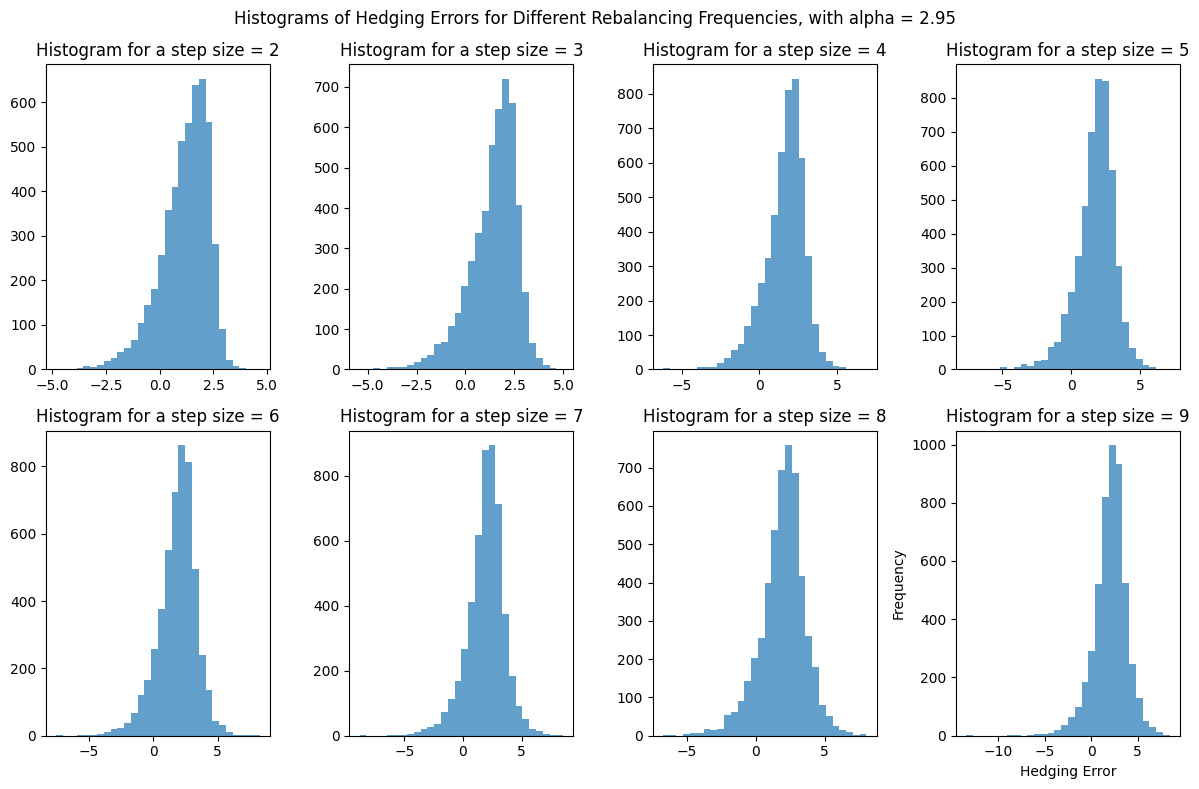

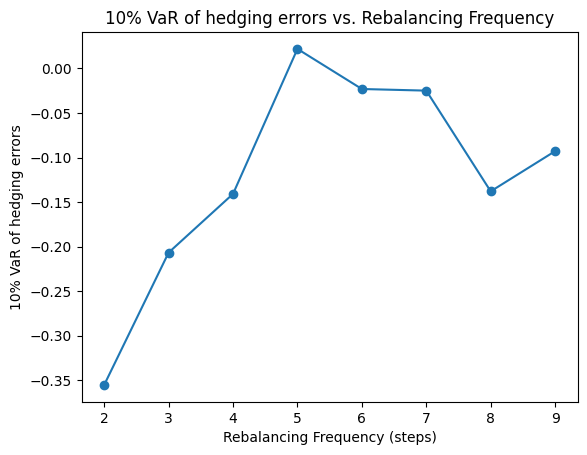

In [ ]:
###Code for question 3.1. PART 2
transaction_cost = 50/10000
S0 = 91.2
K = 100
T = 1.0
r = 0.04
sigma = Tenyears_volatility
alpha = 2.95

N_steps = [2, 3, 4, 5, 6, 7, 8, 9]
num = 5000
dt = 1/252

error = np.zeros((num, len(N_steps)))
total_cost = np.zeros((num, len(N_steps)))
var = []

for n in range(num):

    for j in range(len(N_steps)):
        step = N_steps[j]
        path = GBM_sim(S0, r, T, sigma, 252)
        St = path[0]
        t = path[1]

        d_initial = compute_delta(St[0], K, T, r, sigma)
        a = black_scholes_call_price(S0, K, T, r, sigma)
        initial_cost = d_initial * S0 * transaction_cost
        total_cost[n, j] += initial_cost

        portfolio_values = [a-initial_cost+alpha]
        delta_values = [d_initial]
        equity = [delta_values[0] * S0]
        cash = [portfolio_values[0] - equity[0]]

        # Rebalancing
        for i in range(1, len(t)):

          x = t[i]
          if i % step == 0:
              portfolio_values.append(cash[-1] * np.exp(r * dt) + delta_values[-1] * St[i])
              ttm = T - x
              delta = compute_delta(St[i], K, ttm, r, sigma)
              transaction_cost_amount = transaction_cost * np.abs((delta_values[i-1] - delta) * St[i])
              total_cost[n, j] += transaction_cost_amount
              delta_values.append(delta)
              portfolio_values.append(cash[i - 1] * np.exp(r * dt) + delta_values[i - 1] * St[i] - transaction_cost_amount)
              equity.append(delta * St[i])
              cash.append(portfolio_values[-1] - equity[-1])

          else :
              delta = delta_values[-1]
              delta_values.append(delta)
              equity.append(delta * St[i])
              cash.append(cash[-1]*np.exp(r * dt))
              portfolio_values.append(cash[-1] + equity[-1])

        payoff = max(St[-1] - K, 0)
        error[n, j] = portfolio_values[-1] - payoff

# Plot histograms for hedging errors
plt.figure(figsize=(12, 8))

for i, step in enumerate(N_steps):
    plt.subplot(2, 4, i + 1)
    plt.hist(error[:, i], bins=30, alpha=0.7)
    plt.title(f'Histogram for a step size = {step}')
    mean_value = np.mean(total_cost[:, i])
    print(f"The mean of total_cost for the step size = {step} is: {mean_value}")
    var_10 = np.percentile(error[:,i], 10)
    print(step, f"The 10% VaR of hedging errors is: {var_10}")
    var.append(var_10)

plt.xlabel('Hedging Error')
plt.ylabel('Frequency')
plt.suptitle('Histograms of Hedging Errors for Different Rebalancing Frequencies, with alpha = 2.95')
plt.tight_layout()
plt.show()

# Plot the 10% error
plt.plot(N_steps, var, marker='o')
plt.xlabel('Rebalancing Frequency (steps)')
plt.ylabel('10% VaR of hedging errors')
plt.title('10% VaR of hedging errors vs. Rebalancing Frequency')
plt.show()


In [ ]:
###Code question 3.2.
def implied_volatility(option_price, S, K, T, r, initial_guess=0.27):
    # Define the function to minimize (the difference between market price and Black-Scholes price)
    black_scholes_price = lambda sigma: black_scholes_call_price(S, K, T, r, sigma) - option_price
    implied_volatility = optimize.newton(black_scholes_price, initial_guess)

    return implied_volatility

alpha = 2.95
market_price = 7.87 + alpha
underlying_price = 91.2
strike_price = 100.0
time_to_maturity = 1.0
interest_rate = 0.04

implied_vol = implied_volatility(market_price, underlying_price, strike_price, time_to_maturity, interest_rate)
print(f"Implied Volatility: {implied_vol}")

Implied Volatility: 0.3529861003207511


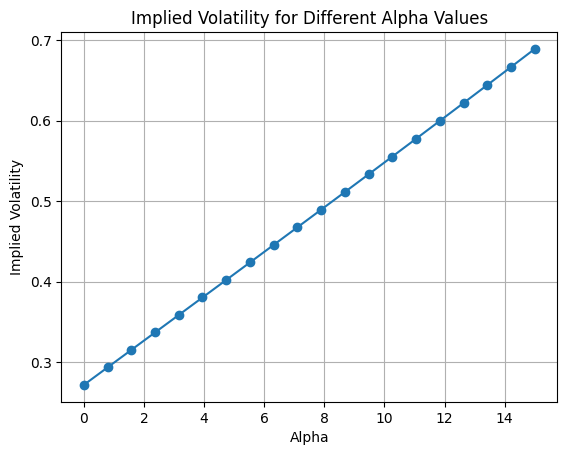

In [ ]:
# Define the range of alpha values
alpha_values = np.linspace(0, 5.0, 20)

# Calculate implied volatility for each alpha value
implied_volatilities = []
for alpha in alpha_values:
    market_price = 7.87 + alpha
    implied_vol = implied_volatility(market_price, underlying_price, strike_price, time_to_maturity, interest_rate)
    implied_volatilities.append(implied_vol)

# Plotting the results
plt.plot(alpha_values, implied_volatilities, marker='o')
plt.title('Implied Volatility for Different Alpha Values')
plt.xlabel('Alpha')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.show()